In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import fstd2nc
import cftime

ModuleNotFoundError: No module named 'fstd2nc'

In [ ]:
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=4, # The number of cores you want
    memory='128 GB', # Amount of memory
    processes=40, # How many processes
    queue='development', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=40:mem=128GB', # Specify resources
    walltime='06:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(1)

# Setup your client
client = Client(cluster)

In [3]:
client

<Client: 'tcp://10.102.15.229:16803' processes=0 threads=0, memory=0 B>

In [4]:
def plot_yg_fields(yin_rlon, yin_rlat, yin_field, yan_rlon, yan_rlat, yan_field, **kwargs):
    '''Create a compound figure of Yin/Yang panels, plotted in rotated coordinates.
    '''
    fig = plt.figure(figsize=(8,14))

    rotated_yan = ccrs.RotatedPole(pole_latitude=8.050,pole_longitude=352.579, central_rotated_longitude=180)
    rotated_yin = ccrs.RotatedPole(pole_latitude=31.758,pole_longitude=87.597)
    data_crs = ccrs.PlateCarree()

    axes_class = (GeoAxes,
                      dict(projection=data_crs))


    grid = AxesGrid(fig, 111, axes_class=axes_class,
                        nrows_ncols=(2, 1),
                        axes_pad=0.25,
                        cbar_location='right',
                        cbar_mode='single',
                        cbar_pad=0.1,
                        cbar_size='3%',
                        label_mode='')  # note the empty label_modead=0.05

    axl = grid[0]
    axl.pcolormesh(yin_rlon, yin_rlat, yin_field,transform=rotated_yin, **kwargs)
    axl.coastlines(linewidth=0.1)  

    axr = grid[1]
    cm = axr.pcolormesh(yan_rlon+180, yan_rlat, yan_field, transform=rotated_yan, **kwargs)
    axr.coastlines(linewidth=0.1)
    grid.cbar_axes[0].colorbar(cm,extend='both')

In [5]:
# These are outputs from a CanAM-GEM AMIP run on the 303x115 grid
ds_amip_yin = xr.open_dataset('/home/ncs001/site5/gemdc-tests/yy_out/yy_out_ng/BEGO_2003010100_00000006_yin.nc')
ds_amip_yan = xr.open_dataset('/home/ncs001/site5/gemdc-tests/yy_out/yy_out_ng/BEGO_2003010100_00000006_yan.nc')

In [6]:
ds_cpl_his0 = xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/users/rcs001/dev-can-hist-cpl_history.nc.001', 
                              chunks={'time':100}) # CanESM5-1 reference cplhis
ds_cpl_his1 = xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/ccrn_tmp/rcs001/maestro/gs-rpt-cpl/gridpt/data/mc_gs-rpt-cpl_1950_m01_cplhist.nc.001', 
                              chunks={'time':100})
ds_cpl_his2 = xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/ccrn_tmp/rcs001/maestro/gs-rpt-cpl/gridpt/data/mc_gs-rpt-cpl_1959_m01_cplhist.nc.001', 
                              chunks={'time':100})

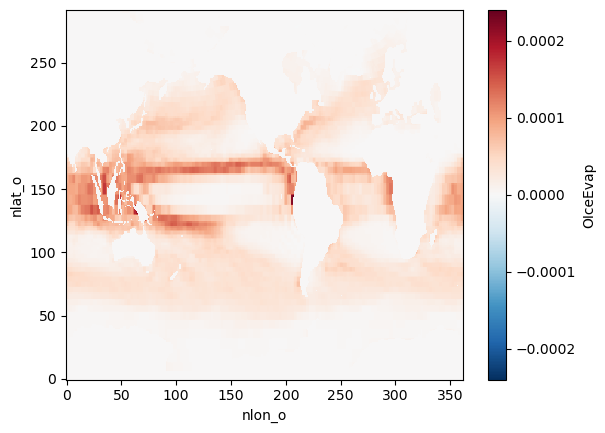

In [12]:
ds_cpl_his0.mean(dim='time').OIceEvap.plot()

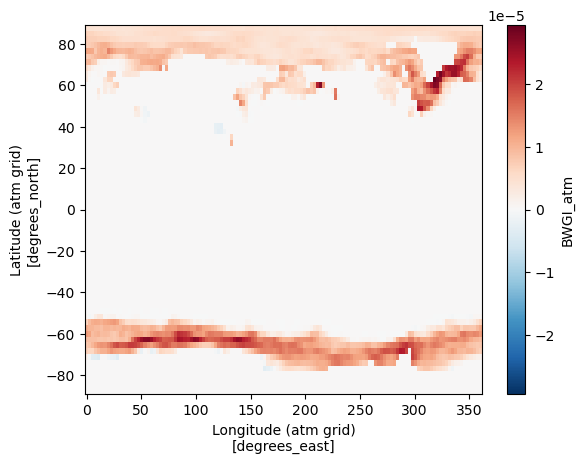

In [13]:
ds_cpl_his0.mean(dim='time').BWGI_atm.plot()

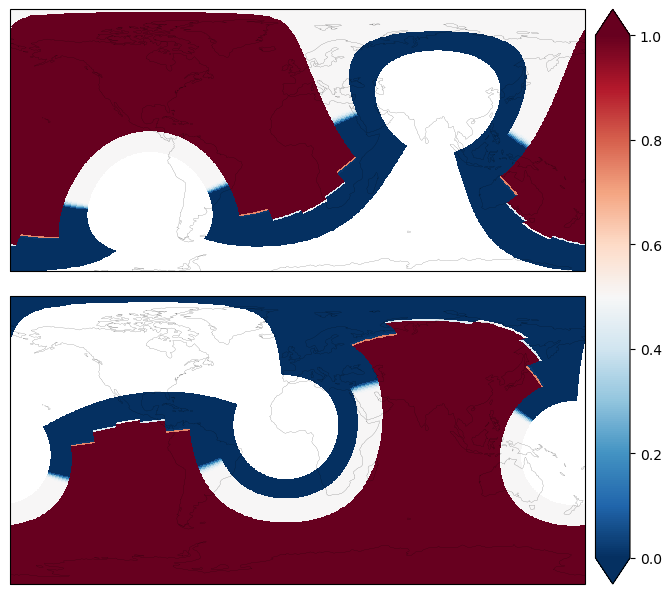

In [40]:
plot_yg_fields(ds_amip_yin.rlon, ds_amip_yin.rlat, ds_cpl_his2_mean.god_weights_atm_yin, 
               ds_amip_yan.rlon, ds_amip_yan.rlat, ds_cpl_his2_mean.god_weights_atm_yang, 
               cmap='RdBu_r', vmin=0, vmax=1)

In [41]:
%%time
ds_cpl_his0_mean = ds_cpl_his0.mean(dim='time').compute(scheduler=client)
ds_cpl_his1_mean = ds_cpl_his1.mean(dim='time').compute(scheduler=client)
ds_cpl_his2_mean = ds_cpl_his2.mean(dim='time').compute(scheduler=client)

CPU times: user 21.5 s, sys: 1.57 s, total: 23.1 s
Wall time: 2min 9s


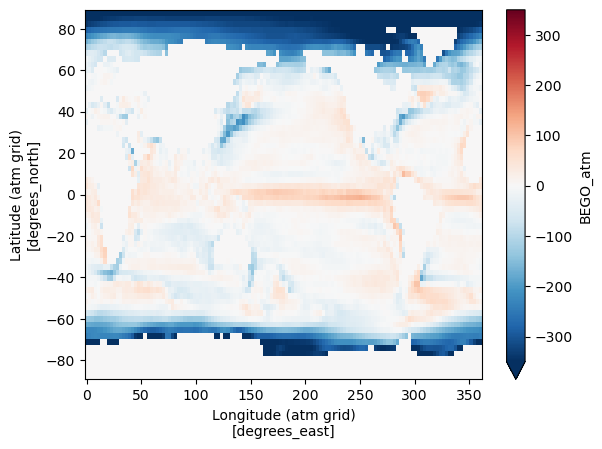

In [42]:
ds_cpl_his0_mean.BEGO_atm.plot(vmin=-350,vmax=350, cmap='RdBu_r')

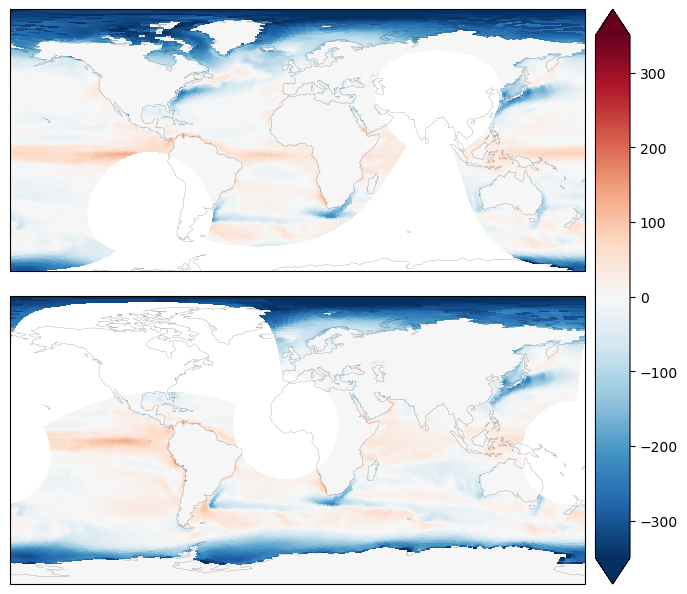

In [43]:
plot_yg_fields(ds_amip_yin.rlon, ds_amip_yin.rlat, ds_cpl_his1_mean.BEGO_atm_yin, 
               ds_amip_yan.rlon, ds_amip_yan.rlat, ds_cpl_his1_mean.BEGO_atm_yang, 
               cmap='RdBu_r', vmin=-350, vmax=350)

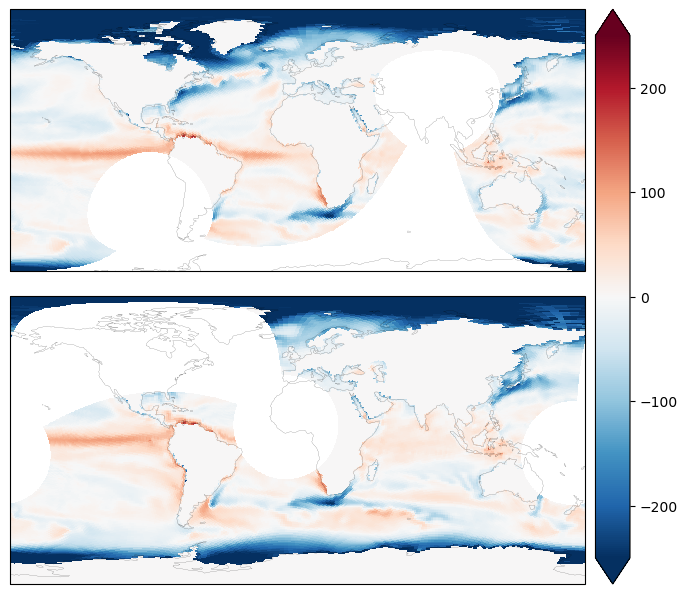

In [44]:
plot_yg_fields(ds_amip_yin.rlon, ds_amip_yin.rlat, ds_cpl_his2_mean.BEGO_atm_yin, 
               ds_amip_yan.rlon, ds_amip_yan.rlat, ds_cpl_his2_mean.BEGO_atm_yang, 
               cmap='RdBu_r', vmin=-250, vmax=250)

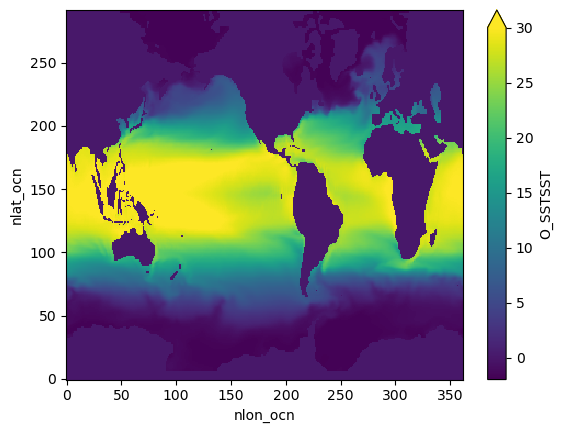

In [45]:
(ds_cpl_his2_mean.O_SSTSST-273.15).plot(vmin=-2, vmax=30)

In [46]:
(ds_cpl_his2_mean.O_SSTSST - ds_cpl_his1_mean.O_SSTSST).plot()

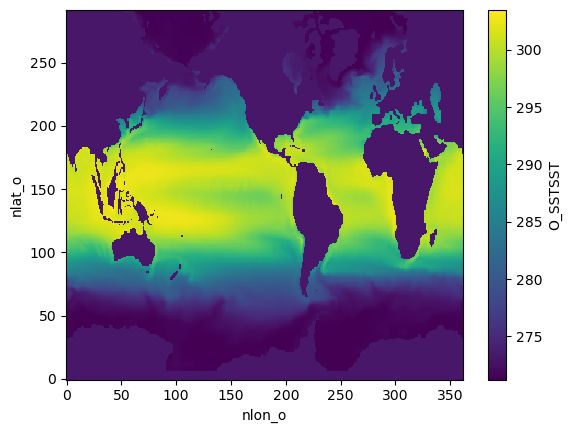

In [47]:
(ds_cpl_his0_mean.O_SSTSST).plot()

In [48]:
ds_cpl_his0_mean.OIceFrc.plot()

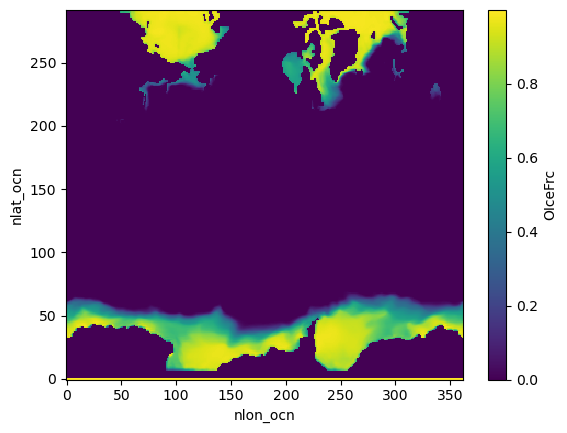

In [49]:
ds_cpl_his1_mean.OIceFrc.plot()

In [50]:
ds_cpl_his2_mean.OIceFrc.plot()

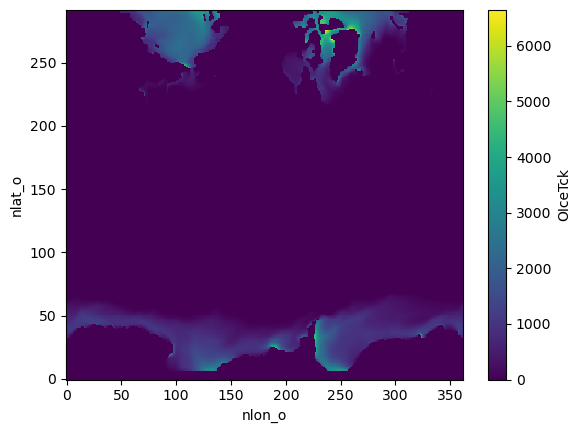

In [51]:
ds_cpl_his0_mean.OIceTck.plot()

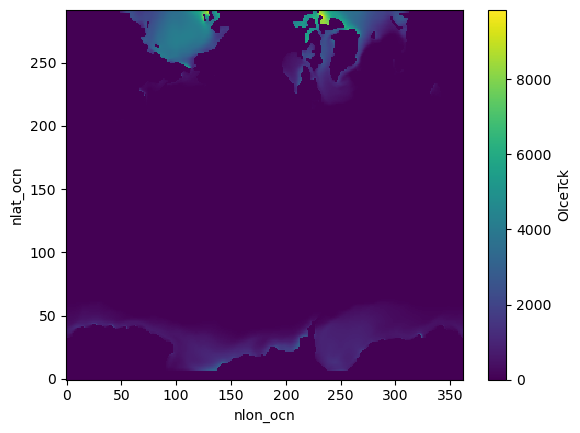

In [52]:
ds_cpl_his2_mean.OIceTck.plot()

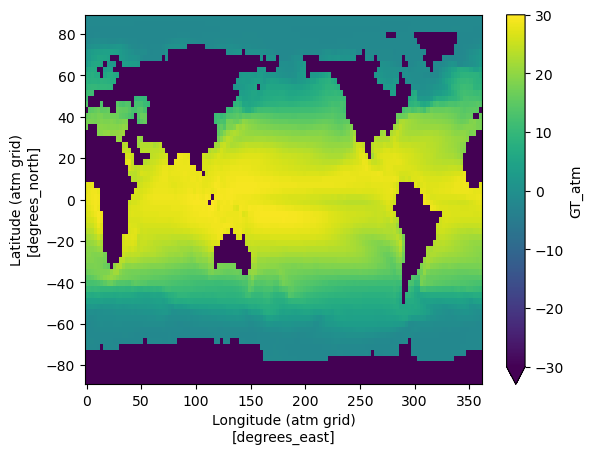

In [53]:
(ds_cpl_his0_mean.GT_atm-273.15).plot(vmin=-30, vmax=30)

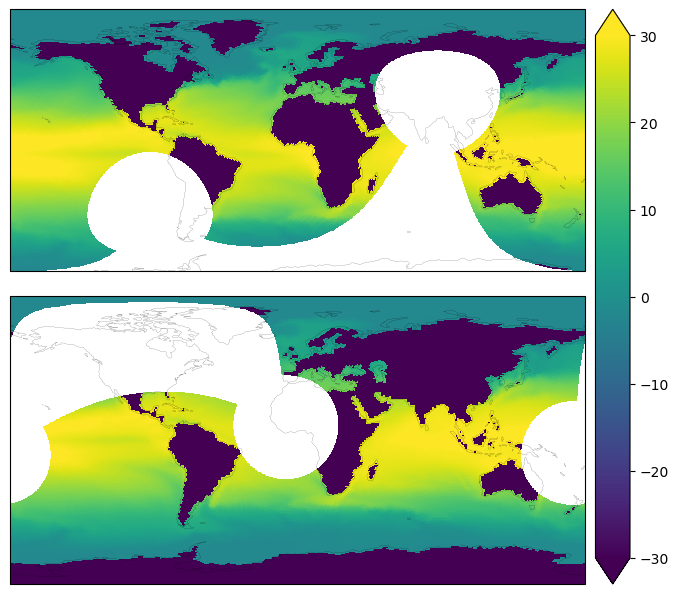

In [54]:
plot_yg_fields(ds_amip_yin.rlon, ds_amip_yin.rlat, ds_cpl_his2_mean.GT_atm_yin-273.15, 
               ds_amip_yan.rlon, ds_amip_yan.rlat, ds_cpl_his2_mean.GT_atm_yang-273.15, 
               vmin=-30, vmax=30)

In [55]:
bego = (ds_cpl_his0.BEGO_atm * (1-ds_cpl_his0.SICN_atm)).mean(dim='time')
bego_gm = (( bego *ds_cpl_his0.atm_grid_cell_area).sum()/ds_cpl_his0.atm_grid_cell_area.sum().values)

In [56]:
((bego*ds_cpl_his0.atm_grid_cell_area).sum()/(ds_cpl_his0.atm_grid_cell_area*(1-ds_cpl_his0.fland_atm)).sum()).compute()

<xarray.DataArray ()>
array(0.16546706)

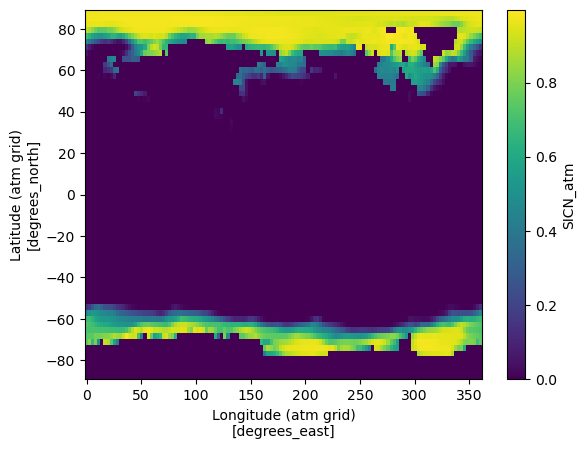

In [57]:
 ds_cpl_his0_mean.SICN_atm.plot()

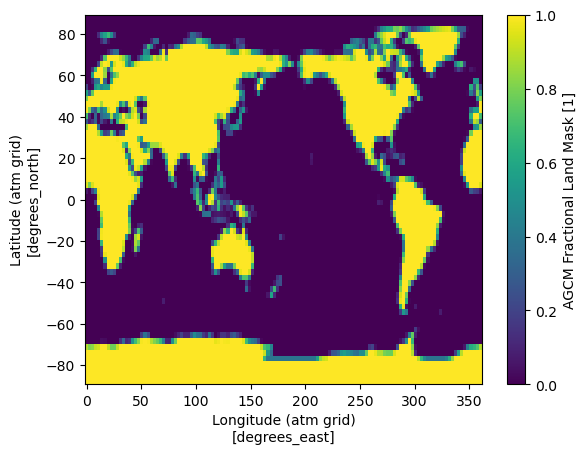

In [58]:
ds_cpl_his0.fland_atm.plot()

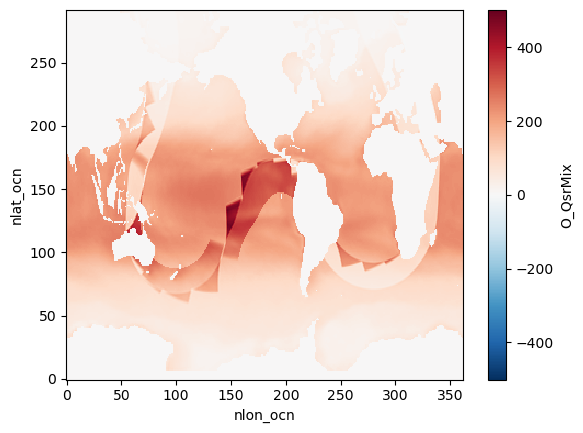

In [60]:
ds_cpl_his2_mean.O_QsrMix.plot()

In [63]:
ds_cpl_his2_mean.O_QnsMix.plot()

In [61]:
ds_cpl_his2_mean

<xarray.Dataset>
Dimensions:               (nlat_atm_yin: 115, nlon_atm_yin: 303,
                           nlat_atm_yang: 115, nlon_atm_yang: 303,
                           nlat_ocn: 292, nlon_ocn: 362)
Dimensions without coordinates: nlat_atm_yin, nlon_atm_yin, nlat_atm_yang,
                                nlon_atm_yang, nlat_ocn, nlon_ocn
Data variables: (12/79)
    lon_atm_yin           (nlat_atm_yin, nlon_atm_yin) float64 245.3 ... 67.72
    lat_atm_yin           (nlat_atm_yin, nlon_atm_yin) float64 -61.39 ... 4.525
    lon_atm_yang          (nlat_atm_yang, nlon_atm_yang) float64 201.4 ... 350.3
    lat_atm_yang          (nlat_atm_yang, nlon_atm_yang) float64 8.226 ... 40.99
    lon_ocn               (nlat_ocn, nlon_ocn) float64 72.5 73.5 ... 73.0 72.99
    lat_ocn               (nlat_ocn, nlon_ocn) float64 -78.39 -78.39 ... 50.01
    ...                    ...
    god_weights_atm_yin   (nlat_atm_yin, nlon_atm_yin) float64 0.0 0.0 ... 0.0
    flno_atm_yin          (nlat_atm_yin, nlon_atm_yin) float64 0.0 0.0 ... 0.0
    cell_area_atm_yang    (nlat_atm_yang, nlon_atm_yang) float64 6.735e+09 .....
    god_weights_atm_yang  (nlat_atm_yang, nlon_atm_yang) float64 0.0 0.0 ... 0.0
    flno_atm_yang         (nlat_atm_yang, nlon_atm_yang) float64 0.0 0.0 ... 0.0
    nemo_tmask            (nlat_ocn, nlon_ocn) float64 0.0 0.0 0.0 ... 0.0 0.0